# AML  xenograft model RNA Samples

In [1]:
import rna2cn.luigi
import luigi
from luigi import LocalTarget
from bioluigi.decorators import inherits, requires
from bioluigi.slurm import SlurmExecutableTask
from bioluigi.utils import CheckTargetNonEmpty
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
with open('/srv/shared/vanloo/rna2cn/sc-all/rna_samples.txt', 'r') as f:
    rna_samples = [x.rstrip() for x in f if x[0] != '#']

In [3]:
class RNABam(luigi.Task):
    base_dir = luigi.Parameter("/srv/shared/vanloo/rna2cn/sc-all")
    sample = luigi.Parameter()
    
    def output(self):
        return LocalTarget(os.path.join(self.base_dir, 'RNA', self.sample, self.sample + ".bam"))
    
    def run(self):
        try:
            os.symlink("/srv/shared/vanloo/home/mtarabichi/sc-all/SC-ALL/pt24/RNA/" + self.sample + ".bam", self.output().path)
        except FileExistsError:
            os.unlink(self.output().path)
            os.symlink("/srv/shared/vanloo/home/mtarabichi/sc-all/SC-ALL/pt24/RNA/" + self.sample + ".bam", self.output().path)

@requires(RNABam)            
class SamtoolsStats(CheckTargetNonEmpty, SlurmExecutableTask):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 8000
        self.n_cpu = 1
        
    def output(self):
        return LocalTarget(os.path.join(os.path.dirname(self.input().path), self.sample + '.txt'))
    
    def work_script(self):
        return '''#!/bin/sh
                  set -euo pipefail
                  module load SAMtools
                  
                  samtools stats {input} > {output}.temp
                  
                  mv {output}.temp {output}
                  '''.format(input=self.input().path,
                             output=self.output().path)
        
@requires(RNABam)
class BAMtoFASTQ(rna2cn.luigi.BAMtoFASTQ):
    pass

@requires(BAMtoFASTQ)
class DeinterleaveBAM(rna2cn.luigi.DeinterleaveBAM):
    pass

@requires(DeinterleaveBAM)
class Trimmomatic(rna2cn.luigi.Trimmomatic):
    pass

@requires(Trimmomatic)
class FastQC(rna2cn.luigi.FastQC):
    pass

@requires(Trimmomatic)
class Kallisto(rna2cn.luigi.Kallisto):
    pass

@inherits(Kallisto)
class AggregateKallisto(rna2cn.luigi.AggregateKallisto):
    sample = None
    def requires(self):
        return {s: self.clone(Kallisto, sample=s) for s in rna_samples} 
    
@requires(Kallisto, SamtoolsStats, FastQC)    
class PerSamplePipeline(luigi.WrapperTask):
    pass
    
@inherits(PerSamplePipeline)    
class SampleWrapper(luigi.WrapperTask):
    sample = None
    def requires(self):
        return [self.clone_parent(sample=s) for s in rna_samples]
    

In [4]:
luigi.build([SampleWrapper(), AggregateKallisto()], local_scheduler=True, workers=100, log_level='INFO')

INFO: Informed scheduler that task   SampleWrapper__srv_shared_vanl_49c4422569   has status   DONE
INFO: Informed scheduler that task   AggregateKallisto__srv_shared_vanl_49c4422569   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 100 processes
INFO: Worker Worker(salt=754050257, workers=100, host=compute008, username=dbunting, pid=15738) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 2 present dependencies were encountered:
    - 1 AggregateKallisto(base_dir=/srv/shared/vanloo/rna2cn/sc-all)
    - 1 SampleWrapper(base_dir=/srv/shared/vanloo/rna2cn/sc-all)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

# RNA Single Cell Analysis

Apply some basic filters: rounding down any meaurement of tpm < 1 to 0, dropping genes expressed in less than 10% of samples and log transforming

In [5]:
df = pd.read_table("/srv/shared/vanloo/rna2cn/sc-all/kallisto_abundances.tsv", header=[0,1], index_col=0)
tpm = df.xs('tpm', level=1, axis=1)


# Set genes with TPM < 1 to 0
tpm = tpm.where(tpm > 1, other=0)
print(tpm.shape)
# Drop genes expressed in < 10% of samples
tpm.drop( tpm[(tpm > 0).mean(axis = 1) < 0.1].index , axis=0, inplace=True)
print(tpm.shape)
# log transform
tpm = np.log2(tpm + 1)
# Drop the ERCC spike ins\
tpm.drop(tpm[tpm.index.str.contains('ERCC')].index, inplace=True, axis=0)

tpm.head()

(180065, 1006)
(24347, 1006)


,VT11b2_N701_S502,VT11b2_N701_S503,VT11b2_N701_S504,VT11b2_N701_S517,VT11b2_N702_S502,VT11b2_N702_S503,VT11b2_N702_S504,VT11b2_N702_S517,VT11b2_N703_S502,VT11b2_N703_S503,...,VT4_N711_S508,VT4_N711_S517,VT4_N712_S502,VT4_N712_S503,VT4_N712_S504,VT4_N712_S505,VT4_N712_S506,VT4_N712_S507,VT4_N712_S508,VT4_N712_S517
target_id,,,,,,,,,,,,,,,,,,,,,
ENST00000534447.5,1.174336,2.593696,2.905020,2.335300,1.704996,3.014595,2.135942,0.000000,1.693226,2.567752,...,0.000000,0.000000,4.739978,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.319228
ENST00000457194.6,1.126345,1.799626,2.798326,0.000000,0.000000,2.386041,1.091747,1.265497,2.442312,1.690936,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
ENST00000493176.1,2.335223,4.214537,4.536619,3.435914,0.000000,3.758005,4.230802,2.143537,3.483119,4.292885,...,0.000000,5.604872,0.000000,0.0,0.000000,2.563161,2.737137,0.000000,0.0,0.000000
ENST00000633705.1,0.000000,1.292428,2.447352,2.154262,2.111475,0.000000,3.490827,1.837628,1.361134,3.293036,...,2.710924,0.000000,0.000000,0.0,2.598818,0.000000,0.000000,3.015803,0.0,0.000000
ENST00000611116.1,3.017134,1.927824,0.000000,0.000000,3.226627,5.407716,0.000000,0.000000,2.222839,4.984229,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


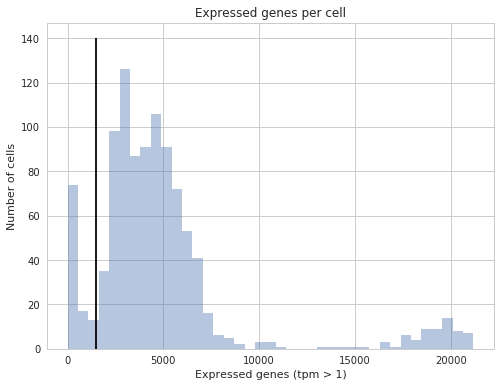

In [6]:
plt.figure(figsize=(8,6))
sns.distplot((tpm > 0).sum(axis=0), kde=False)
plt.xlabel("Expressed genes (tpm > 1)")
plt.ylabel("Number of cells")
plt.title("Expressed genes per cell")
plt.vlines(1500, 0,140)

A cutoff of 1500 genes per cell seems about right to avoid cutting off the bulk of the cells.
This drops 99 cells

In [7]:
tpm.drop( tpm.columns[(tpm > 0).sum(axis = 0) < 1500] , axis=1, inplace=True)
tpm.shape

(24347, 907)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


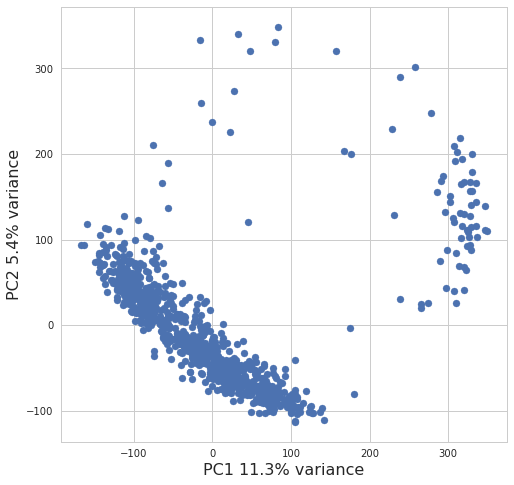

In [8]:
pca = sklearn.decomposition.PCA(2)
transformed = pca.fit_transform(tpm.T)

plt.figure(figsize=(8,8))
plt.scatter(transformed[:,0], transformed[:,1],)
plt.xlabel("PC1 {0:.1f}% variance".format(pca.explained_variance_ratio_[0]*100), size=16)
plt.ylabel("PC2 {0:.1f}% variance".format(pca.explained_variance_ratio_[1]*100), size=16)